## Gurobi example

In [1]:
from optiwindnet.importer import load_repository
from optiwindnet.svg import svgplot
from optiwindnet.mesh import make_planar_embedding
from optiwindnet.interarraylib import G_from_S
from optiwindnet.heuristics import EW_presolver
from optiwindnet.MILP import pyomo as omo
from optiwindnet.pathfinding import PathFinder

In [2]:
from pyomo import environ as pyo

### Initialize Gwynt y Mor

In [3]:
locations = load_repository()

In [4]:
L = locations.gwynt
capacity = 6

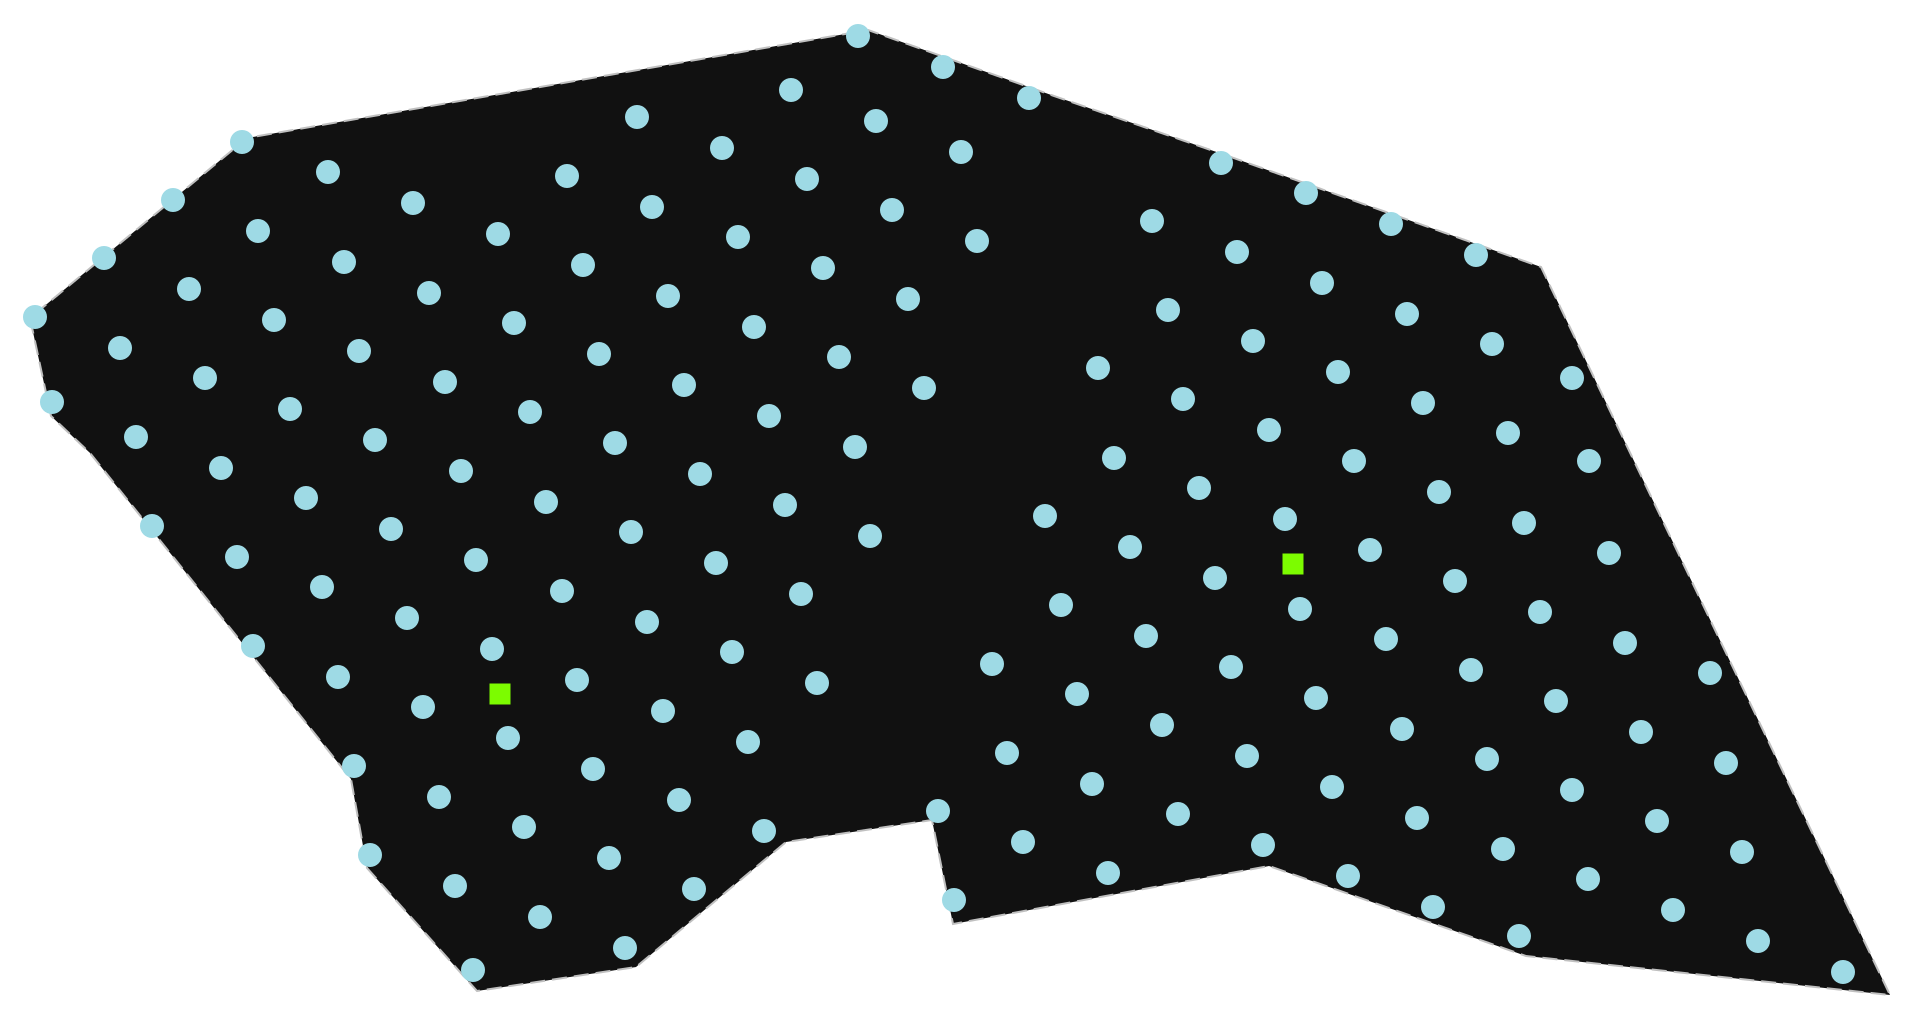

In [5]:
svgplot(L)

### Optimize Gwynt y Mor

In [6]:
P, A = make_planar_embedding(L)

Initial heuristic solution to warm-start the solver:

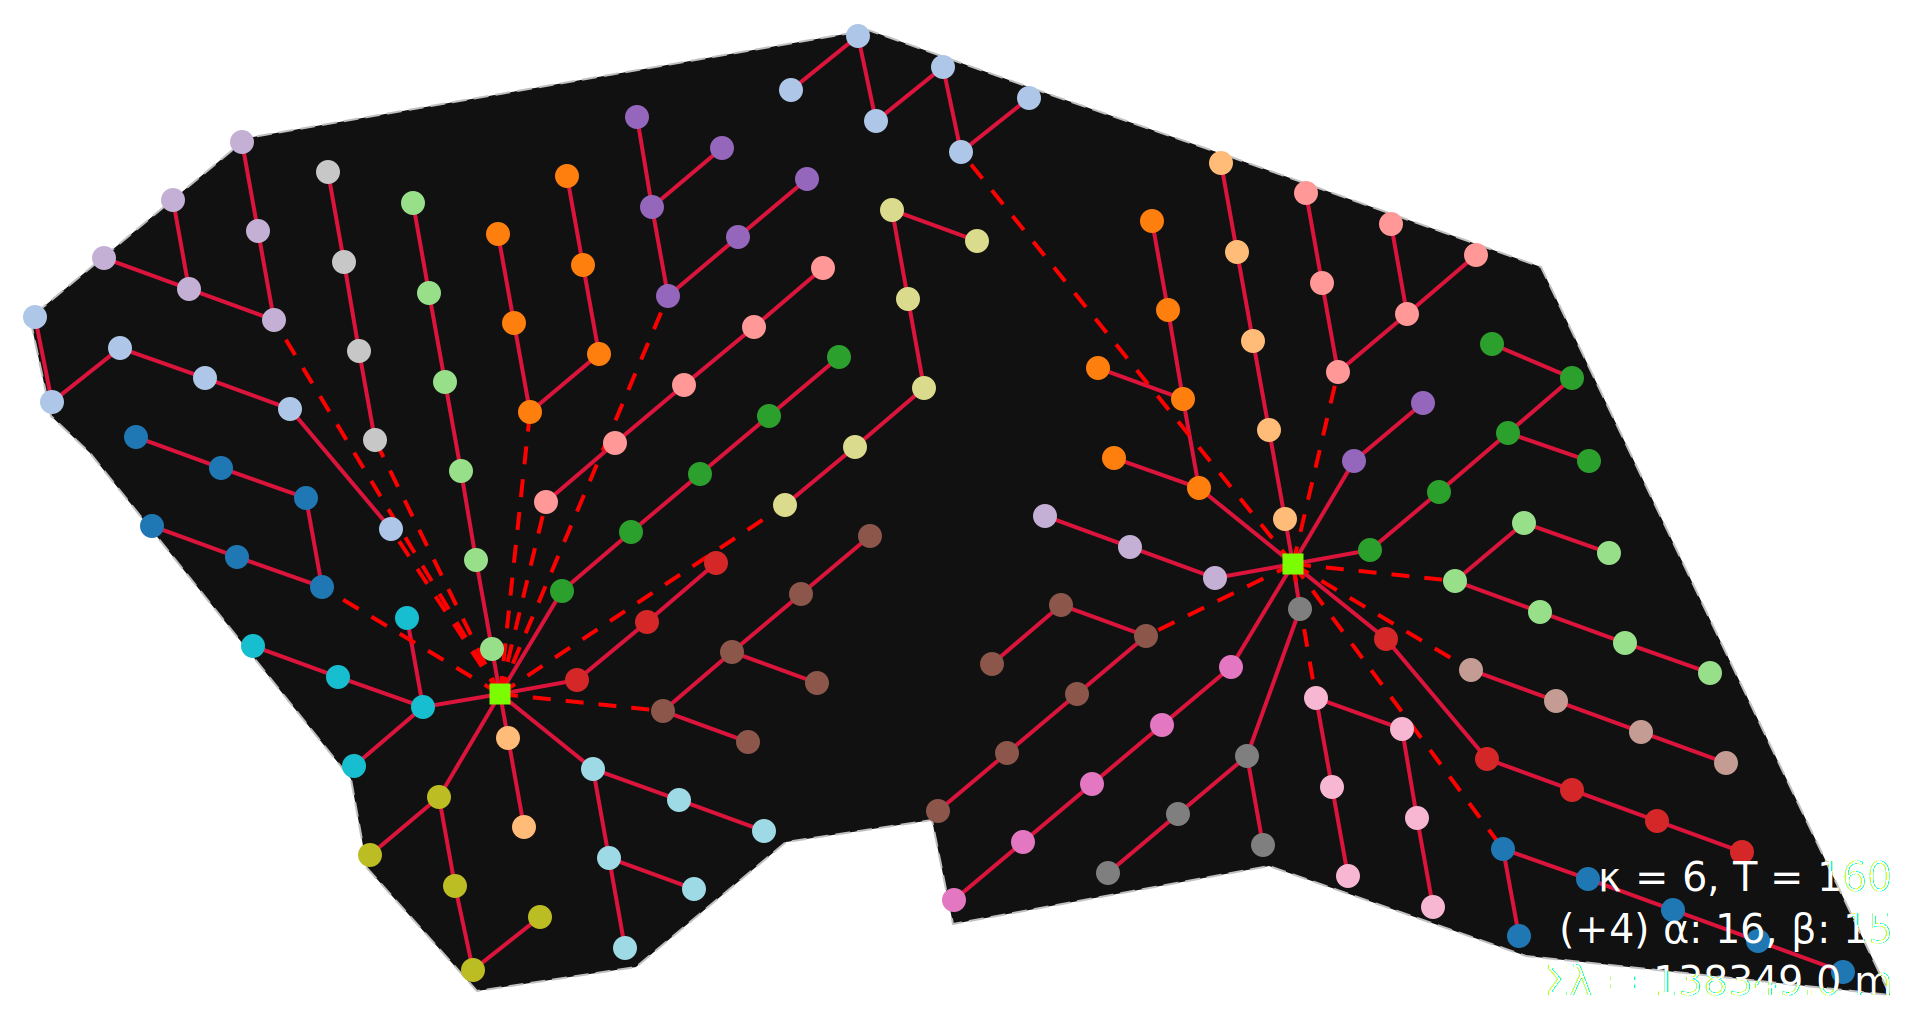

In [7]:
Sʹ = EW_presolver(A, capacity=capacity)
Gʹ = G_from_S(Sʹ, A)
svgplot(Gʹ)

In [8]:
model = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    branching=True,
    gates_limit=False
)
omo.warmup_model(model, Sʹ);

The pyomo GurobiDirect class can work as context manager by passing the `manage_env=True` parameter to SolverFactory. Advantages of operating this way:
- the Gurobi license is released after the context's scope ends
- one can pass `options` that can only be set at the Gurobi environment creation (such as `threadlimit`)

In [9]:
with pyo.SolverFactory('gurobi', solver_io='python', manage_env=True,
                       options={'threadlimit': 16}) as gurober:
    print(gurober.available(), type(gurober))
    gurober.options.mipgap = 0.005  # relative lower-bound to objective-value gap
    gurober.options.timelimit = 90  # seconds
    gurober.options.mipfocus = 1  # focus on producing solutions
    print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, κ={model.k.value}}}\n')
    result = gurober.solve(model, warmstart=model.warmed_by, tee=True)

ModuleNotFoundError: No module named 'gurobipy'


ApplicationError: No Python bindings available for <class 'pyomo.solvers.plugins.solvers.gurobi_direct.GurobiDirect'> solver plugin

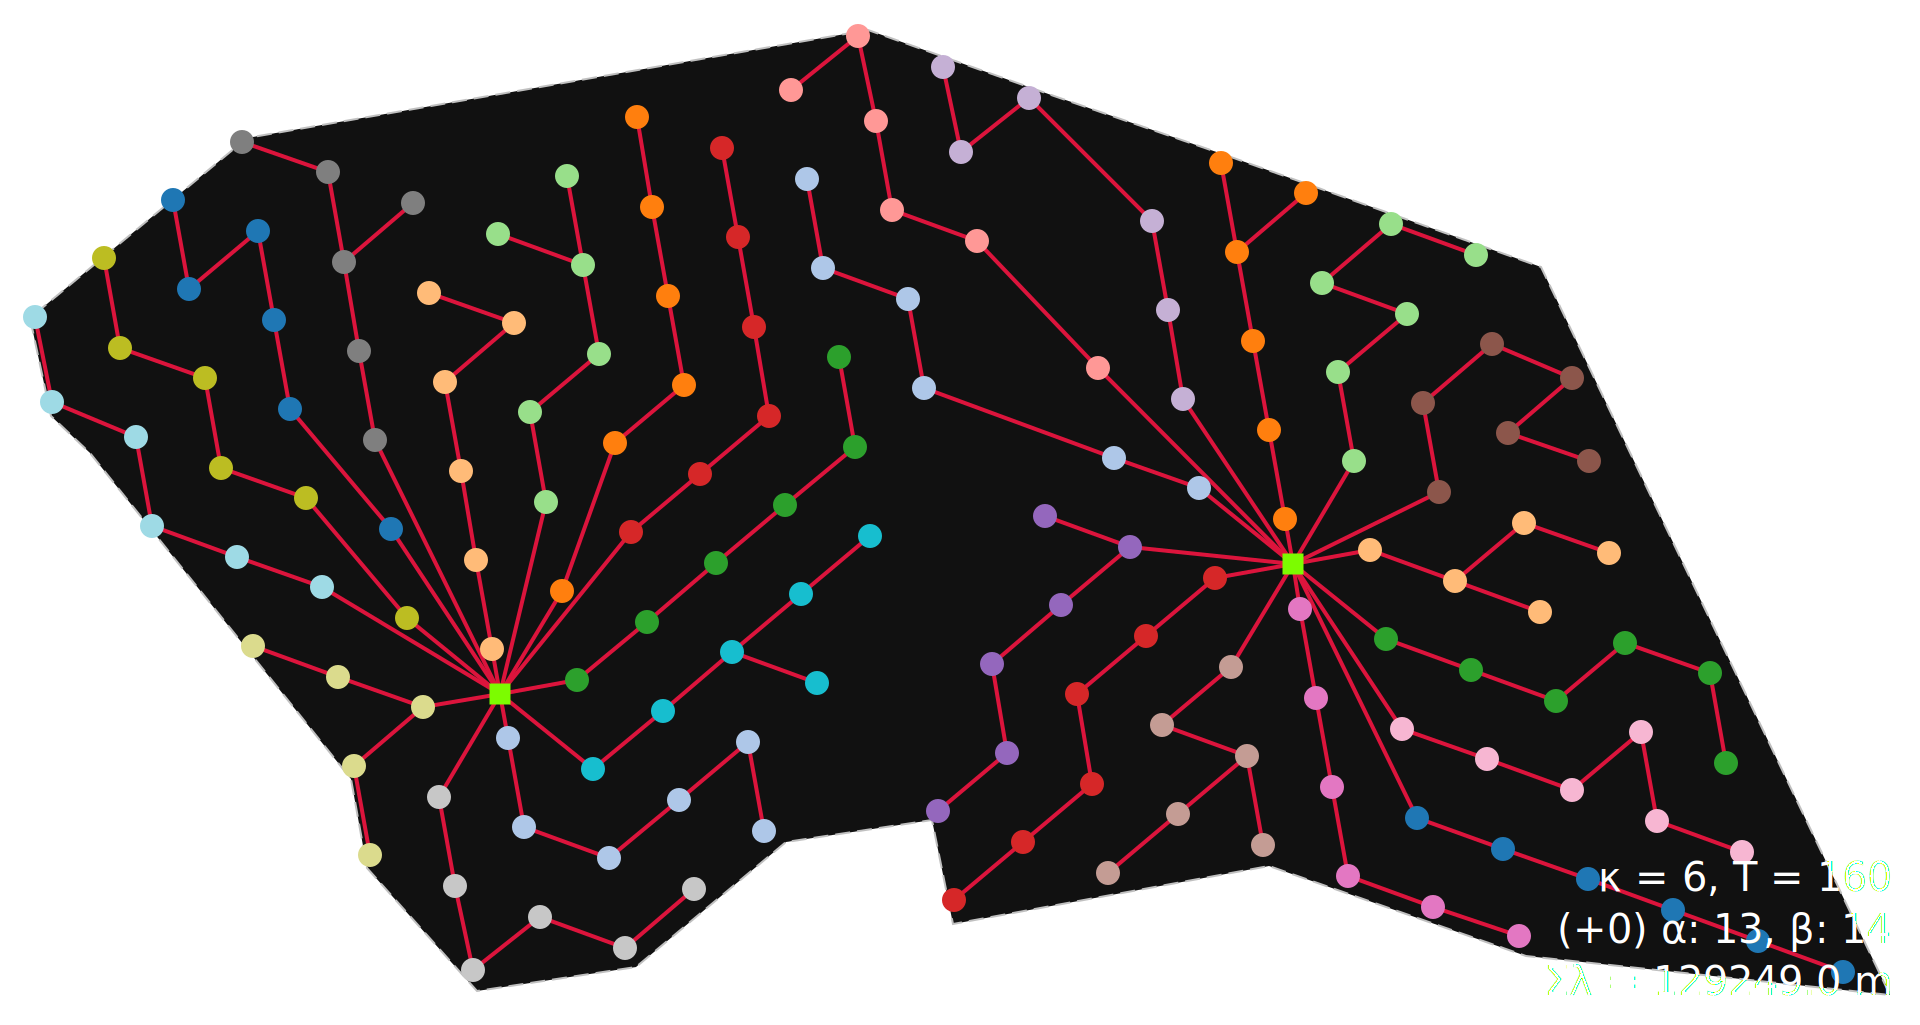

In [ ]:
S = omo.S_from_solution(model, gurober, result)
G = G_from_S(S, A)
H = PathFinder(G, planar=P, A=A).create_detours()
svgplot(H)